# LSTM

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

%matplotlib inline
from rl.config import config
from rl.marketdata.yahoodownloader import YahooDownloader
from rl.preprocessing.preprocessors import FeatureEngineer
from rl.preprocessing.data import data_split
from rl.env.env_stocktrading import StockTradingEnv
from rl.model.models import DRLAgent
from rl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import itertools
import seaborn as sns

D:\InstalledSoftware\anaconda3\envs\py37-python-notebook\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [5]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [6]:
import tkinter
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf

In [7]:
pd.set_option('display.max_columns', None)

In [8]:
# from config.py start_date is a string
start_date = config.START_DATE
# from config.py end_date is a string
end_date = config.END_DATE
# from config.py split_date is a string
split_date = config.SPLIT_DATE
# config target ticker
target_ticker = config.SP500_20_TICKER.copy()
target_ticker.extend(['SPY'])
# config tech_indicator_list
tech_indicator_list = config.TECHNICAL_INDICATORS_LIST
print("training period: {}-{}, testing period: {}-{}\n".format(start_date, split_date, split_date, end_date))
print("target ticker list:\n {}\n".format(target_ticker))
print("tech_indicator_list:\n {}\n".format(tech_indicator_list))

training period: 2000-01-01-2019-01-01, testing period: 2019-01-01-2021-01-01

target ticker list:
 ['AAPL', 'MSFT', 'AMZN', 'BRK-B', 'JPM', 'JNJ', 'UNH', 'HD', 'PG', 'NVDA', 'DIS', 'BAC', 'CMCSA', 'XOM', 'VZ', 'T', 'ADBE', 'PFE', 'CSCO', 'INTC', 'SPY']

tech_indicator_list:
 ['macd', 'boll_ub', 'boll_lb', 'rsi_10', 'rsi_20', 'cci_10', 'cci_20', 'dx_30', 'close_20_sma', 'close_60_sma', 'close_120_sma', 'close_20_ema', 'close_60_ema', 'close_120_ema']



## Dataset

In [9]:
df = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = target_ticker).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [10]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,0.936384,1.004464,0.907924,0.859423,535796800.0,AAPL,0
1,2000-01-03,16.812500,16.875000,16.062500,16.274673,7384400.0,ADBE,0
2,2000-01-03,81.500000,89.562500,79.046875,89.375000,16117600.0,AMZN,0
3,2000-01-03,25.125000,25.125000,24.000000,13.952057,13705800.0,BAC,0
4,2000-01-03,36.500000,36.580002,34.820000,35.299999,875000.0,BRK-B,0


### Assign reasonable value between gap

In [11]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicator_list,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [12]:
processed.shape
processed.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_10,rsi_20,cci_10,cci_20,dx_30,close_20_sma,close_60_sma,close_120_sma,close_20_ema,close_60_ema,close_120_ema,turbulence
0,2000-01-03,0.936384,1.004464,0.907924,0.859423,535796800.0,AAPL,0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,0.859423,0.859423,0.859423,0.859423,0.859423,0.859423,0.0
1,2000-01-03,16.812500,16.875000,16.062500,16.274673,7384400.0,ADBE,0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,16.274673,16.274673,16.274673,16.274673,16.274673,16.274673,0.0
2,2000-01-03,81.500000,89.562500,79.046875,89.375000,16117600.0,AMZN,0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,89.375000,89.375000,89.375000,89.375000,89.375000,89.375000,0.0
3,2000-01-03,25.125000,25.125000,24.000000,13.952057,13705800.0,BAC,0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,13.952057,13.952057,13.952057,13.952057,13.952057,13.952057,0.0
4,2000-01-03,36.500000,36.580002,34.820000,35.299999,875000.0,BRK-B,0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,35.299999,35.299999,35.299999,35.299999,35.299999,35.299999,0.0


In [13]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])
processed_full = processed_full.fillna(0)

In [14]:
processed_full

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_10,rsi_20,cci_10,cci_20,dx_30,close_20_sma,close_60_sma,close_120_sma,close_20_ema,close_60_ema,close_120_ema,turbulence
0,2000-01-03,AAPL,0.936384,1.004464,0.907924,0.859423,535796800.0,0.0,0.000000,0.925665,0.720723,0.000000,0.000000,-66.666667,-66.666667,100.000000,0.859423,0.859423,0.859423,0.859423,0.859423,0.859423,0.000000
1,2000-01-03,ADBE,16.812500,16.875000,16.062500,16.274673,7384400.0,0.0,0.000000,0.925665,0.720723,0.000000,0.000000,-66.666667,-66.666667,100.000000,16.274673,16.274673,16.274673,16.274673,16.274673,16.274673,0.000000
2,2000-01-03,AMZN,81.500000,89.562500,79.046875,89.375000,16117600.0,0.0,0.000000,0.925665,0.720723,0.000000,0.000000,-66.666667,-66.666667,100.000000,89.375000,89.375000,89.375000,89.375000,89.375000,89.375000,0.000000
3,2000-01-03,BAC,25.125000,25.125000,24.000000,13.952057,13705800.0,0.0,0.000000,0.925665,0.720723,0.000000,0.000000,-66.666667,-66.666667,100.000000,13.952057,13.952057,13.952057,13.952057,13.952057,13.952057,0.000000
4,2000-01-03,BRK-B,36.500000,36.580002,34.820000,35.299999,875000.0,0.0,0.000000,0.925665,0.720723,0.000000,0.000000,-66.666667,-66.666667,100.000000,35.299999,35.299999,35.299999,35.299999,35.299999,35.299999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161044,2020-12-31,SPY,371.779999,374.660004,371.230011,372.659454,78520700.0,3.0,3.953809,372.629176,361.515288,70.903466,65.323094,105.368123,159.113762,43.796707,367.072232,353.564373,342.006158,366.400775,355.331731,342.473709,6.605555
161045,2020-12-31,T,28.450001,28.799999,28.389999,27.784883,38622300.0,3.0,-0.124263,30.484001,26.709769,42.863063,47.738897,-45.001733,-78.746607,0.632669,28.596885,27.569604,27.758198,28.136238,27.916311,28.017975,6.605555
161046,2020-12-31,UNH,345.040009,351.089996,344.049988,349.438538,1969000.0,3.0,2.021413,351.262515,331.093298,65.625493,59.407863,106.203581,92.374500,20.137052,341.177907,334.577781,320.251363,340.840582,333.328448,321.561674,6.605555
161047,2020-12-31,VZ,58.060001,58.799999,58.020000,57.509003,12906300.0,3.0,-0.405310,60.927017,56.565592,38.857274,43.717139,-88.627052,-111.605035,18.422305,58.746305,58.124588,57.459786,58.287243,58.182467,57.398980,6.605555


In [15]:
processed_full.sort_values(['date','tic'], ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_10,rsi_20,cci_10,cci_20,dx_30,close_20_sma,close_60_sma,close_120_sma,close_20_ema,close_60_ema,close_120_ema,turbulence
0,2000-01-03,AAPL,0.936384,1.004464,0.907924,0.859423,535796800.0,0.0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,0.859423,0.859423,0.859423,0.859423,0.859423,0.859423,0.0
1,2000-01-03,ADBE,16.812500,16.875000,16.062500,16.274673,7384400.0,0.0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,16.274673,16.274673,16.274673,16.274673,16.274673,16.274673,0.0
2,2000-01-03,AMZN,81.500000,89.562500,79.046875,89.375000,16117600.0,0.0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,89.375000,89.375000,89.375000,89.375000,89.375000,89.375000,0.0
3,2000-01-03,BAC,25.125000,25.125000,24.000000,13.952057,13705800.0,0.0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,13.952057,13.952057,13.952057,13.952057,13.952057,13.952057,0.0
4,2000-01-03,BRK-B,36.500000,36.580002,34.820000,35.299999,875000.0,0.0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,35.299999,35.299999,35.299999,35.299999,35.299999,35.299999,0.0
5,2000-01-03,CMCSA,16.145832,16.333332,15.062500,12.189544,2333700.0,0.0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,12.189544,12.189544,12.189544,12.189544,12.189544,12.189544,0.0
6,2000-01-03,CSCO,54.968750,55.125000,51.781250,40.118656,53076000.0,0.0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,40.118656,40.118656,40.118656,40.118656,40.118656,40.118656,0.0
7,2000-01-03,DIS,28.855125,29.533344,28.361876,23.115248,8402230.0,0.0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,23.115248,23.115248,23.115248,23.115248,23.115248,23.115248,0.0
8,2000-01-03,HD,68.625000,69.187500,63.812500,42.563168,12030800.0,0.0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,42.563168,42.563168,42.563168,42.563168,42.563168,42.563168,0.0
9,2000-01-03,INTC,41.632812,43.687500,41.625000,27.002798,57710200.0,0.0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,27.002798,27.002798,27.002798,27.002798,27.002798,27.002798,0.0


### Example data

In [16]:
SPY=processed_full[processed_full['tic']=='SPY']

In [17]:
SPY=SPY.reset_index(drop=True)

In [18]:
SPY[SPY['date']<='2018-12-31']

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_10,rsi_20,cci_10,cci_20,dx_30,close_20_sma,close_60_sma,close_120_sma,close_20_ema,close_60_ema,close_120_ema,turbulence
0,2000-01-03,SPY,148.250000,148.250000,143.875000,97.825676,8164300.0,0.0,0.000000,0.925665,0.720723,0.000000,0.000000,-66.666667,-66.666667,100.000000,97.825676,97.825676,97.825676,97.825676,97.825676,97.825676,0.000000
1,2000-01-04,SPY,143.531250,144.062500,139.640625,94.000107,8089800.0,1.0,-0.085830,101.323063,90.502720,0.000000,0.000000,-66.666667,-66.666667,100.000000,95.912891,95.912891,95.912891,95.817252,95.881012,95.896952,0.000000
2,2000-01-05,SPY,139.937500,141.531250,137.250000,94.168259,12177900.0,2.0,-0.104150,99.654922,91.007772,4.656445,4.422206,-74.379225,-74.379225,100.000000,95.331347,95.331347,95.331347,95.211752,95.290959,95.311090,0.000000
3,2000-01-06,SPY,139.625000,141.500000,137.750000,92.654861,6227200.0,3.0,-0.164571,99.092325,90.232127,3.177043,3.116525,-70.167063,-70.167063,100.000000,94.662226,94.662226,94.662226,94.473617,94.598624,94.630340,0.000000
4,2000-01-07,SPY,140.312500,145.750000,140.062500,98.035896,8066500.0,4.0,0.020186,100.218011,90.455909,57.066205,53.976000,50.001537,50.001537,13.341918,95.336960,95.336960,95.336960,95.335302,95.332659,95.334343,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774,2018-12-24,SPY,239.039993,240.839996,234.270004,225.031799,147311600.0,0.0,-7.226676,272.629782,228.518626,13.835890,24.705654,-156.646862,-204.180271,59.992621,250.574204,259.196484,265.133717,246.794452,256.582543,260.064099,33.809894
4775,2018-12-26,SPY,235.970001,246.179993,233.759995,236.401520,218485400.0,2.0,-7.135700,272.430247,226.819979,37.845416,37.590126,-86.220986,-134.698689,43.882618,249.625113,258.510650,264.940695,245.804649,255.920870,259.672982,60.311147
4776,2018-12-27,SPY,242.570007,248.289993,238.960007,238.216446,186267300.0,3.0,-6.838324,271.850335,225.597280,40.772577,39.334468,-47.421876,-97.890827,38.012856,248.723808,257.838993,264.744502,245.081963,255.340397,259.318328,10.543894
4777,2018-12-28,SPY,249.580002,251.399994,246.449997,237.909164,153100200.0,4.0,-6.551920,270.213864,224.810404,40.414525,39.139507,-2.688613,-66.843204,29.677603,247.512134,257.164921,264.526106,244.398840,254.768881,258.964458,12.182358


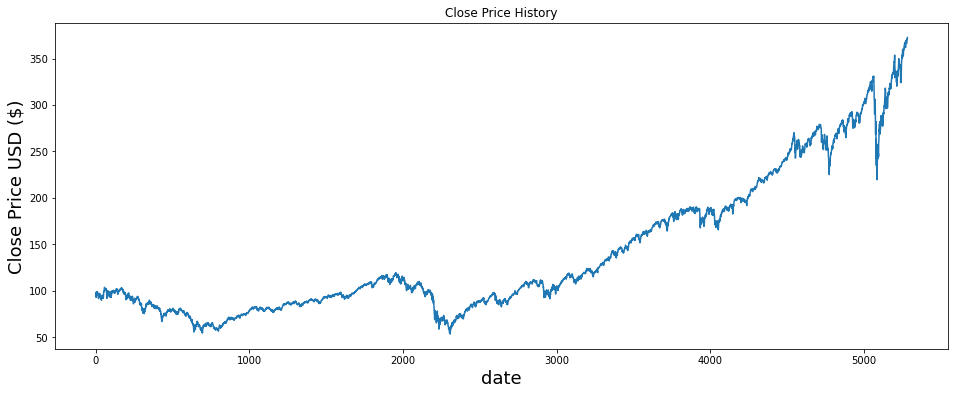

In [19]:
%matplotlib inline

plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(SPY['close'])
plt.xlabel('date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [29]:
np.array(range(len(SPY))),

array([   0,    1,    2, ..., 5281, 5282, 5283])

In [50]:
def linear_polyfit(ticker, ):
    coefficients=np.polyfit(np.array(range(len(ticker))), np.array(ticker['close']), 1)
    poly = np.poly1d(coefficients)
    poly_x = np.array(range(len(SPY)))
    poly_y = poly(poly_x)
    return poly_x, poly_y

def exp_polyfit(ticker, ):
    coefficients=np.polyfit(np.array(range(len(ticker))), np.log(np.array(ticker['close'])), 1)
    poly = np.poly1d(coefficients)
    poly_x = np.array(range(len(SPY)))
    poly_y = np.exp(poly(poly_x))
    return poly_x, poly_y

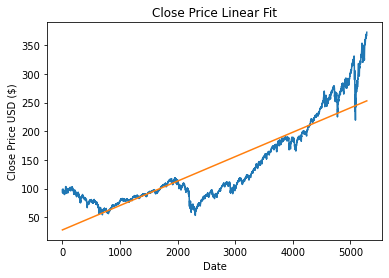

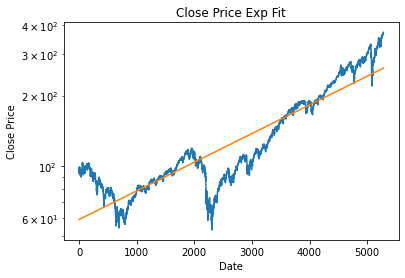

In [57]:
%matplotlib inline

_, poly_y = linear_polyfit(SPY)
plt.figure()
plt.title('Close Price Linear Fit')
plt.plot(SPY['close'], label='close_price')
plt.plot(poly_y, label='linear_fit')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.show()

_, poly_y = exp_polyfit(SPY)
plt.figure()
plt.title('Close Price Exp Fit')
plt.plot(SPY['close'], label='close_price')
plt.plot(poly_y, label='log_fit')
plt.xlabel('Date')
plt.yscale("log")
plt.ylabel('Close Price')
plt.show()

In [32]:
np.polyfit(np.array(range(len(SPY))), np.array(SPY['close']), 1)

array([ 0.04259842, 27.97404441])

### Parameters Define

In [31]:
# Training feature_columns
feature_columns = ['close', 'open', 'high', 'low', 'volume', 'day', 'macd',
       'boll_ub', 'boll_lb', 'rsi_10', 'rsi_20', 'cci_10', 'cci_20', 'dx_30',
       'close_20_sma', 'close_60_sma', 'close_120_sma', 'close_20_ema',
       'close_60_ema', 'close_120_ema', 'turbulence']

# Hyperparameters Define:
shift = 1
input_width = 90 # per quarter
train_idx = 4779 # get date from 2000 to 2018-12-31
print("Training data from 0 to {}".format(train_idx))

Training data from 0 to 4779


In [32]:
# log convert price related values
# log_feature_columns = ['close', 'open', 'high', 'low', 'boll_ub', 'boll_lb', 'rsi_10', 'rsi_20', 'cci_10', 'cci_20', 'dx_30',
#        'close_20_sma', 'close_60_sma', 'close_120_sma', 'close_20_ema',
#        'close_60_ema', 'close_120_ema']

# def log_convert(data, log_feature_columns):
#     for feature in log_feature_columns:
#         data[feature]=np.log(data[feature])
#     return data
# processed_full=log_convert(log_convert, log_feature_columns)

In [33]:
def scale_df(df, feature_columns):
    tics = df.tic.unique()
    scalers = {}
    dataset = {}
    scaled_dataset = {}
    for tic in tics:
        dataset[tic] = df[df['tic']==tic].filter(feature_columns).values
        # Most of stock long term increase, so here may have some skew, reserve the range not full.
        scalers[tic] = MinMaxScaler(feature_range=(0.2,0.8))
        scaled_dataset[tic] = scalers[tic].fit_transform(dataset[tic])
    return scalers, dataset, scaled_dataset
scalers, dataset, scaled_dataset = scale_df(processed_full, feature_columns)

In [34]:
# Create the training data set 
# Create the scaled training data set
# Split the data into x_train and y_train data sets
def data_window_split(df, train_idx, input_width, shift):
    """
    Split dataset to time series windows
    df: data frame
    train_len: training dataset length
    input_width: training time series length
    shift: offset between x and y
    """
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    for i in range(input_width - 1, len(df) - shift):
        if i <= train_idx:
            x_train.append(df[i - input_width + 1: i + 1, :])
            y_train.append(df[i + shift, 0])
        else:
            x_test.append(df[i - input_width + 1: i + 1, :])
            y_test.append(df[i + shift, 0])
    
    x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

    return x_train, y_train, x_test, y_test

def data_prepare(full_stock_data, train_idx, input_width, shift):
    """
    data_prepare: prepare dataset by ticker.
    """
    x_train_dict = {}
    y_train_dict = {}
    x_test_dict = {}
    y_test_dict = {}
    for k in full_stock_data.keys():
        data = full_stock_data[k]
        x_train_dict[k], y_train_dict[k], x_test_dict[k], y_test_dict[k] = data_window_split(data, train_idx, input_width, shift)
        
        print(k, x_train_dict[k].shape, y_train_dict[k].shape, x_test_dict[k].shape, y_test_dict[k].shape)
    return x_train_dict, y_train_dict, x_test_dict, y_test_dict

x_train_dict, y_train_dict, x_test_dict, y_test_dict = data_prepare(scaled_dataset, train_idx, input_width, shift)

AAPL (4691, 90, 21) (4691,) (503, 90, 21) (503,)
ADBE (4691, 90, 21) (4691,) (503, 90, 21) (503,)
AMZN (4691, 90, 21) (4691,) (503, 90, 21) (503,)
BAC (4691, 90, 21) (4691,) (503, 90, 21) (503,)
BRK-B (4691, 90, 21) (4691,) (503, 90, 21) (503,)
CMCSA (4691, 90, 21) (4691,) (503, 90, 21) (503,)
CSCO (4691, 90, 21) (4691,) (503, 90, 21) (503,)
DIS (4691, 90, 21) (4691,) (503, 90, 21) (503,)
HD (4691, 90, 21) (4691,) (503, 90, 21) (503,)
INTC (4691, 90, 21) (4691,) (503, 90, 21) (503,)
JNJ (4691, 90, 21) (4691,) (503, 90, 21) (503,)
JPM (4691, 90, 21) (4691,) (503, 90, 21) (503,)
MSFT (4691, 90, 21) (4691,) (503, 90, 21) (503,)
NVDA (4691, 90, 21) (4691,) (503, 90, 21) (503,)
PFE (4691, 90, 21) (4691,) (503, 90, 21) (503,)
PG (4691, 90, 21) (4691,) (503, 90, 21) (503,)
SPY (4691, 90, 21) (4691,) (503, 90, 21) (503,)
T (4691, 90, 21) (4691,) (503, 90, 21) (503,)
UNH (4691, 90, 21) (4691,) (503, 90, 21) (503,)
VZ (4691, 90, 21) (4691,) (503, 90, 21) (503,)
XOM (4691, 90, 21) (4691,) (503, 9

In [35]:
def merge_tic(x_dict, y_dict):
    """
    Merge Tickers to one dataset
    """
    x = np.concatenate(tuple(x_dict.values()), axis=0)
    y = np.concatenate(tuple(y_dict.values()), axis=0)
    return x, y
x_train, y_train = merge_tic(x_train_dict, y_train_dict)
y_train.shape

(98511,)

In [36]:
def model_fit_by_dict(
    x_train_dict, 
    y_train_dict, 
    model, 
    batch_size=1, 
    epochs=1, 
    validation_split=0.1):
    x_train, y_train = merge_tic(x_train_dict, y_train_dict)
    x_train, y_train = shuffle(x_train, y_train)
    history = model.fit(
        x_train, 
        y_train, 
        batch_size = batch_size, 
        epochs=epochs, 
        validation_split=validation_split
    )
    return history

def model_fit_by_tic(x_train_dict, y_train_dict, model, batch_size=1, epochs=1, validation_split=0.1):
    loss_r=[]
    val_loss_r=[]
    for i in range(epochs):
        print("======== epochs: {} ========".format(i))
        
        val_loss = 0
        for k in x_train_dict:
            x_train, y_train = x_train_dict[k], y_train_dict[k]
            x_train, y_train = shuffle(x_train, y_train)
            history = model.fit(x_train, y_train, batch_size = batch_size, epochs=1, validation_split=validation_split)
            loss.append(history.history['loss'])
            val_loss.append(history.history['val_loss'])
        loss_r.append(np.mean(loss))
        val_loss_r.append(np.mean(val_loss))
    history.history['loss'] = loss_r
    history.history['val_loss'] = val_loss_r
    return history

In [37]:
models = {}
histories = {}

In [39]:
%%time

# Build the LSTM model
def build_simple_lstm0(name, optimizer='adam', loss='mean_squared_error'):
    model = Sequential(name=name)
    model.add(LSTM(512, return_sequences=True, input_shape=(input_width, len(feature_columns))))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dense(64))
    model.add(Dense(1))
    model.compile(
        optimizer=optimizer, loss=loss
    )
    model.summary()
    return model

models['simple_lstm0'] = build_simple_lstm0('simple_lstm0')

def model_fit(x_train, y_train, model, batch_size, epochs):
    x_train, y_train = shuffle(x_train, y_train)
    history = model.fit(x_train, y_train, validation_split = 0.1, batch_size = batch_size, epochs=epochs)
    return history

histories['simple_lstm0'] = model_fit(x_train_dict['SPY'], y_train_dict['SPY'], models['simple_lstm0'], batch_size=32, epochs=10)

Model: "simple_lstm0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 90, 512)           1093632   
_________________________________________________________________
lstm_9 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 1,897,601
Trainable params: 1,897,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


UnknownError:    Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[simple_lstm0/lstm_8/PartitionedCall]] [Op:__inference_train_function_27056]

Function call stack:
train_function -> train_function -> train_function


In [ ]:
%%time

# Build the LSTM model
def build_simple_lstm(optimizer='adam', loss='mean_squared_error'):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(input_width, len(feature_columns))))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(
        optimizer=optimizer, loss=loss
    )
    model.summary()
    return model

models['simple_lstm1'] = build_simple_lstm()
histories['simple_lstm1'] = model_fit_by_dict(x_train_dict, y_train_dict, models['simple_lstm1'], batch_size=16, epochs=5)

In [ ]:
%%time

def build_simple_lstm_2(optimizer='adam', loss='mean_squared_error'):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(input_width, len(feature_columns))))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(
        optimizer=optimizer, loss=loss
    )
    model.summary()
    return model

models['simple_lstm2'] = build_simple_lstm_2()

histories['simple_lstm2'] = model_fit_by_tic(x_train_dict, y_train_dict, models['simple_lstm2'], batch_size=32, epochs=5)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 90, 256)           284672    
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 826,497
Trainable params: 826,497
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
4221/4221 [==============================] - 51s 12ms/step - loss: 0.0018 - val_loss: 1.2953e-04
Epoch 2/2
4221/4221 [==============================] - 46s 11ms/step - loss: 2.0947e-04 - val_loss: 4.3695e-05
Wall time: 1min 37s


In [ ]:
%%time

def build_simple_lstm_3(optimizer='adam', loss='mean_squared_error'):
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=(input_width, len(feature_columns))))
    model.add(LSTM(512, return_sequences=False))
    model.add(Dense(64))
    model.add(Dense(1))
    model.compile(
        optimizer=optimizer, loss=loss
    )
    model.summary()
    return model

models['simple_lstm3'] = build_simple_lstm_3()
histories['simple_lstm3'] = model_fit_by_dict(x_train_dict, y_train_dict, models['simple_lstm3'], batch_size=16, epochs=6)

In [ ]:
%%time

def build_simple_lstm_6(optimizer='adam', loss='mean_squared_error'):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(input_width, len(feature_columns))))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(
        optimizer=optimizer, loss=loss
    )
    model.summary()
    return model

models['simple_lstm6'] = build_simple_lstm_6()
histories['simple_lstm6'] = model_fit_by_dict(x_train_dict, y_train_dict, models['simple_lstm6'], batch_size=256, epochs=7)

In [ ]:
%%time

def build_simple_lstm_7(optimizer='adam', loss='mean_squared_error'):
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=(input_width, len(feature_columns))))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(
        optimizer=optimizer, loss=loss
    )
    model.summary()
    return model

models['simple_lstm7'] = build_simple_lstm_7()
histories['simple_lstm7'] = model_fit_by_dict(x_train_dict, y_train_dict, models['simple_lstm7'], batch_size=256, epochs=7)

In [ ]:
%%time

def build_simple_lstm_8(optimizer='adam', loss='mean_squared_error'):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(input_width, len(feature_columns))))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(
        optimizer=optimizer, loss=loss
    )
    model.summary()
    return model

models['simple_lstm8'] = build_simple_lstm_8()
histories['simple_lstm8'] = model_fit_by_dict(x_train_dict, y_train_dict, models['simple_lstm8'], batch_size=64, epochs=8)

In [ ]:
%%time

def build_simple_lstm_9(optimizer='adam', loss='mean_squared_error'):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(input_width, len(feature_columns))))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(
        optimizer=optimizer, loss=loss
    )
    model.summary()
    return model

models['simple_lstm9'] = build_simple_lstm_9()
histories['simple_lstm9'] = model_fit_by_dict(x_train_dict, y_train_dict, models['simple_lstm9'], batch_size=64, epochs=6)

In [103]:
def build_simple_lstm_10(optimizer='adam', loss='mean_squared_error'):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(input_width, len(feature_columns))))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(
        optimizer=optimizer, loss=loss
    )
    model.summary()
    return model

models['simple_lstm10'] = build_simple_lstm_10()
# histories['simple_lstm10'] = model_fit_by_dict(x_train_dict, y_train_dict, models['simple_lstm10'], batch_size=32, epochs=6)
model_fit_by_dict(x_train_dict, y_train_dict, models['simple_lstm10'], batch_size=32, epochs=6)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 90, 256)           284672    
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_10 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 485,953
Trainable params: 485,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
3079/3079 [==============================] - 51s 16ms/step - loss: 0.0019 1s - loss: 0 - ET
Epoch 2/6
3079/3079 [==============================] - 49s 16ms/step - loss: 6.2768e-05
Epoch 3/6
3079/3079 [==============================] - 4

In [109]:
def build_simple_lstm_101(optimizer='adam', loss='mean_squared_error'):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(input_width, len(feature_columns))))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(
        optimizer=optimizer, loss=loss
    )
    model.summary()
    return model

models['simple_lstm101'] = build_simple_lstm_101(loss=tf.keras.losses.LogCosh())
# histories['simple_lstm10'] = model_fit_by_dict(x_train_dict, y_train_dict, models['simple_lstm10'], batch_size=32, epochs=6)
model_fit_by_dict(x_train_dict, y_train_dict, models['simple_lstm101'], batch_size=32, epochs=6)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 90, 256)           284672    
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_16 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 485,953
Trainable params: 485,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
3079/3079 [==============================] - 54s 17ms/step - loss: 0.0020
Epoch 2/6
3079/3079 [==============================] - 51s 16ms/step - loss: 3.3875e-05
Epoch 3/6
3079/3079 [==============================] - 51s 17ms/step - los

In [108]:
def build_simple_lstm_102(optimizer='adam', loss='mean_squared_error'):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(input_width, len(feature_columns))))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(
        optimizer=optimizer, loss=loss
    )
    model.summary()
    return model

models['simple_lstm102'] = build_simple_lstm_102(loss=tf.keras.losses.Huber())
# histories['simple_lstm10'] = model_fit_by_dict(x_train_dict, y_train_dict, models['simple_lstm10'], batch_size=32, epochs=6)
model_fit_by_dict(x_train_dict, y_train_dict, models['simple_lstm102'], batch_size=32, epochs=6)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 90, 256)           284672    
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_14 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 485,953
Trainable params: 485,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
3079/3079 [==============================] - 53s 16ms/step - loss: 9.1500e-04
Epoch 2/6
3079/3079 [==============================] - 49s 16ms/step - loss: 2.9979e-05
Epoch 3/6
3079/3079 [==============================] - 48s 16ms/step -

In [ ]:
%%time

def build_simple_lstm_11(optimizer='adam', loss='mean_squared_error'):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(input_width, len(feature_columns))))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dense(64))
    model.add(Dense(1))
    model.compile(
        optimizer=optimizer, loss=loss
    )
    model.summary()
    return model

models['simple_lstm11'] = build_simple_lstm_10()
histories['simple_lstm11'] = model_fit_by_dict(x_train_dict, y_train_dict, models['simple_lstm11'], batch_size=64, epochs=20)

In [ ]:
%%time

def build_simple_lstm_12(optimizer='adam', loss='mean_squared_error'):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(input_width, len(feature_columns))))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(64))
    model.add(Dense(1))
    model.compile(
        optimizer=optimizer, loss=loss
    )
    model.summary()
    return model

models['simple_lstm12'] = build_simple_lstm_10()
histories['simple_lstm12'] = model_fit_by_dict(x_train_dict, y_train_dict, models['simple_lstm12'], batch_size=16, epochs=8)

In [29]:
type(histories['simple_lstm10'].history['loss'])

list

### Learning Curves

In [25]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.yscale("log")
    plt.title('Training and Validation Loss')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
%matplotlib inline
plot_history(histories['simple_lstm0'])
plot_history(histories['simple_lstm1'])
# plot_history(histories['simple_lstm2'])
plot_history(histories['simple_lstm3'])
plot_history(histories['simple_lstm4'])
plot_history(histories['simple_lstm5'])
plot_history(histories['simple_lstm6'])
plot_history(histories['simple_lstm7'])
plot_history(histories['simple_lstm8'])

In [ ]:
%matplotlib inline
plot_history(histories['simple_lstm0'])
plot_history(histories['simple_lstm1'])
# plot_history(histories['simple_lstm2'])
plot_history(histories['simple_lstm3'])
plot_history(histories['simple_lstm4'])
plot_history(histories['simple_lstm5'])
plot_history(histories['simple_lstm6'])
plot_history(histories['simple_lstm7'])
plot_history(histories['simple_lstm8'])
plot_history(histories['simple_lstm9'])
plot_history(histories['simple_lstm10'])

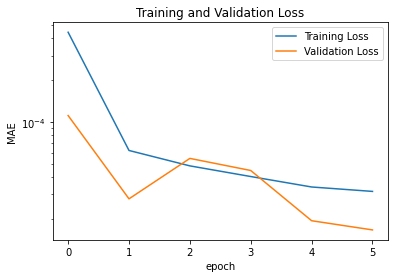

In [93]:
%matplotlib inline
plot_history(histories['simple_lstm10'])

In [ ]:
%matplotlib inline

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
# plotter = tfdocs.plots.HistoryPlotter(smoothing_std=10)
# plotter.plot(histories['simple_lstm'])
# plt.ylim([0.5, 0.7])
plt.plot(histories['simple_lstm10'].history['loss'], label='MAE (training data)')
plt.yscale("log")
plt.show()
print(histories['simple_lstm10'].history)

### Prediction

In [27]:
def retrain(x_train, y_train, model, batch_size=1, epochs=1):
    history = model.fit(x_train, y_train, batch_size = batch_size, epochs=epochs)
    return history

def inverse_transform_y(y_data, scaler, y_col_idx):
    a = np.zeros(shape=(len(y_data), scaler.scale_.shape[0]))
    a[:,y_col_idx]=y_data[:,0]
    return scaler.inverse_transform(a)[:,0]

def predict(x, y_val, model):
    y = model.predict(x)
    rmse = np.sqrt(np.mean(((y - y_val) ** 2)))
    print(rmse)
    return y, rmse

In [128]:
x_train, y_train, x_test, y_test = x_train_dict['SPY'], y_train_dict['SPY'], x_test_dict['SPY'], y_test_dict['SPY']
model = models['simple_lstm102']
retrain(x_train, y_train, model, batch_size=32, epochs=3)

Epoch 1/3
147/147 [==============================] - 2s 17ms/step - loss: 4.6751e-06
Epoch 2/3
147/147 [==============================] - 2s 17ms/step - loss: 5.2303e-06
Epoch 3/3
147/147 [==============================] - 3s 17ms/step - loss: 4.8334e-06


In [129]:
y_train_predict, _ = predict(x_train, y_train, model)
y_test_predict, _ = predict(x_test, y_test, model)

train_predict = inverse_transform_y(y_train_predict, scalers['SPY'], y_col_idx=0)
train_val = inverse_transform_y(np.reshape(y_train, (y_train.shape[0], 1 )), scalers['SPY'], y_col_idx=0)
test_predict = inverse_transform_y(y_test_predict, scalers['SPY'], y_col_idx=0)
test_val = inverse_transform_y(np.reshape(y_test, (y_test.shape[0], 1 )), scalers['SPY'], y_col_idx=0)

0.14802288190673676
0.08126860495826699


In [130]:
train = SPY[input_width + shift - 1 : len(x_train) + input_width + shift - 1].copy()
train['predict']=train_predict
train['val']=train_val
valid = SPY[len(x_train) + input_width + shift - 1 :].copy()
valid['predict'] = test_predict
valid['val']=test_val

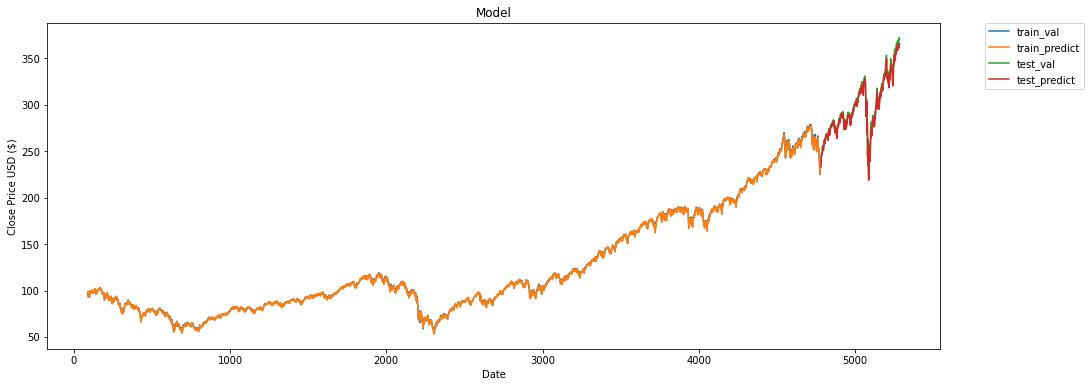

In [131]:
%matplotlib inline

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Close Price USD ($)', fontsize=10)
plt.plot(train['val'], label='train_val')
plt.plot(train['predict'], label='train_predict')
plt.plot(valid['val'], label='test_val')
plt.plot(valid['predict'], label='test_predict')
# plt.plot(train[['val','predict']])
# plt.plot(valid[['val','predict']])
# plt.legend(['Train', 'Train_Predict' 'Test', 'Test_Predict'], loc='lower right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

### Trading

A simple strategy base on prediction:
- condition1: if predict price lower than current price, hold cash
- condition2: if predict price higher than or equal to current price, hold share

In [132]:
def trading(prev_price, real_price, predict_price):
    prev_portfolio = 1.0
    records = [prev_portfolio]
    for i in range(len(real_price)):
        if predict_price[i] > prev_price[i]:
            portfolio = (prev_portfolio / prev_price[i]) * real_price[i]
        else:
            portfolio = prev_portfolio
        prev_portfolio = portfolio
        records.append(prev_portfolio)
    return records

def gen_prev_price(begin_price, real_price):
    """
    Generate Previous Value
    """
    prev_price=real_price.copy()[:-1]
    return np.insert(prev_price, 0, begin_price)
prev_val = gen_prev_price(train_val[-1], test_val)

In [133]:
records=trading(prev_val, test_val, test_predict)

In [134]:
np.array(records).shape

(504,)

In [135]:
test_val.shape

(503,)

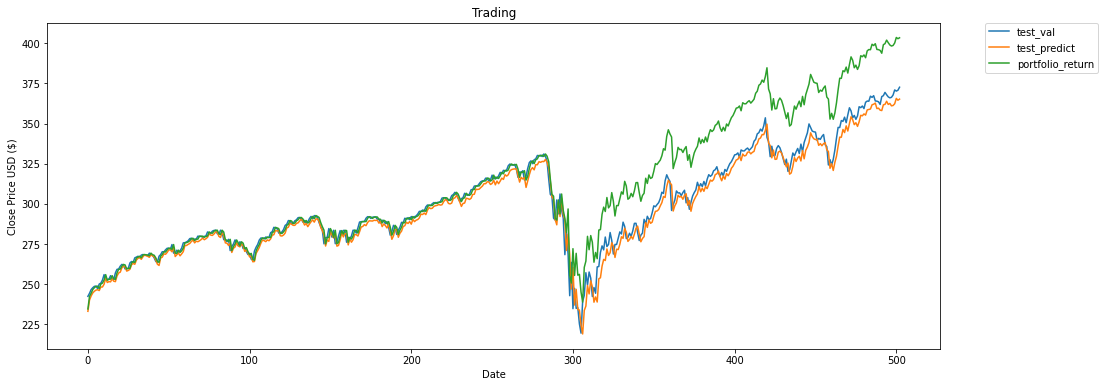

In [137]:
%matplotlib inline

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Trading')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Close Price USD ($)', fontsize=10)
plt.plot(test_val, label='test_val')
plt.plot(test_predict, label='test_predict')
plt.plot(records[1:]*prev_val, label='portfolio_return')
# plt.plot(train[['val','predict']])
# plt.plot(valid[['val','predict']])
# plt.legend(['Train', 'Train_Predict' 'Test', 'Test_Predict'], loc='lower right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()